# Using SkLearn to Create a Linear Regression Model for Huntington Beach Housing Prices

In this project I will use data sourced from Zillow to create a model to predict the price of a single family home in Huntington Beach, California using SKLearn.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

pd.options.display.float_format = "{:.2f}".format


Now that the neccesary packages are installed we can import the data. This was obtained from Zillow.

In [57]:
#put the data into a data frame
df_data = pd.read_csv('Home.csv')

Zillow has a lot of data that may be useful for a person looking to purchase a home but only a few categories relevant to examing factors that affect price. We will have to clean the data frame of all useless data.

In [58]:
df_data.columns

Index(['Property URL', 'MLS ID', 'Property type', 'Property price (USD)',
       'Sold date (MM/DD/YYYY)', 'Living area', 'Living area unit',
       'Price per living area unit (USD)', 'Lot/land area',
       'Lot/land area unit', 'Bedrooms', 'Bathrooms', 'Street address', 'City',
       'Zip', 'State', 'Country'],
      dtype='object')

In [59]:
df_data = df_data[['Property price (USD)','Living area', 'Lot/land area','Bedrooms', 'Bathrooms']]
df_data.columns

Index(['Property price (USD)', 'Living area', 'Lot/land area', 'Bedrooms',
       'Bathrooms'],
      dtype='object')

We now have a the data categories we want.

Now that we have the correct categories, we have to further clean the data by removing outliers. 

In [60]:
saleprice_scaled = StandardScaler().fit_transform(np.array(df_data['Property price (USD)']).reshape(-1, 1))
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:5]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-5:]

print("outer range (low) of the distribution:")
print(low_range, '\n')
print("outer range (high) of the distribution:")
print(high_range)

outer range (low) of the distribution:
[[-1.89566695]
 [-1.66057129]
 [-1.50553524]
 [-1.45724532]
 [-1.44453745]] 

outer range (high) of the distribution:
[[3.68944332]
 [4.84585978]
 [4.96023064]
 [5.38594439]
 [7.56534464]]


From this we can see that there is an outlier with a value of 7.56. However before simply removing it is a good idea to see if it is actually negatively affecting our data. This can be done with visual analysis of our data.

In [61]:
print(df_data['Property price (USD)'].describe(), '\n')
print(df_data['Living area'].describe(), '\n')
print(df_data['Bedrooms'].describe(), '\n')
print(df_data['Bathrooms'].describe(), '\n')
print(df_data['Lot/land area'].describe())


count       652.00
mean    1696726.37
std      787517.90
min      205000.00
25%     1230000.00
50%     1453500.00
75%     1903750.00
max     7650000.00
Name: Property price (USD), dtype: float64 

count    651.00
mean    2100.80
std      818.28
min      485.00
25%     1479.00
50%     1947.00
75%     2608.50
max     6399.00
Name: Living area, dtype: float64 

count   651.00
mean      3.64
std       0.88
min       1.00
25%       3.00
50%       4.00
75%       4.00
max       8.00
Name: Bedrooms, dtype: float64 

count   651.00
mean      2.82
std       1.09
min       1.00
25%       2.00
50%       3.00
75%       3.00
max      12.00
Name: Bathrooms, dtype: float64 

count     649.00
mean     5518.64
std      1684.91
min         0.26
25%      5000.00
50%      6000.00
75%      6429.00
max     10350.00
Name: Lot/land area, dtype: float64


Looking at the maxs and mins of the data is also helpful as it helps us see outliers. There are some outliers on the higher end of Bathrooms and on the lower end of Lot/Area

<Axes: xlabel='Bathrooms', ylabel='Property price (USD)'>

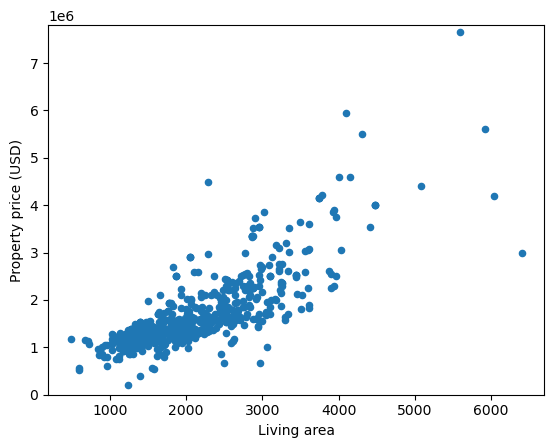

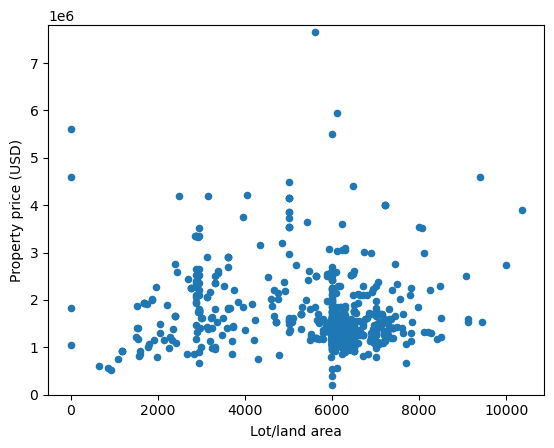

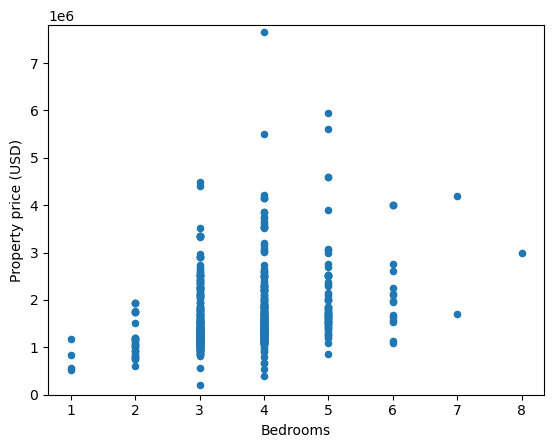

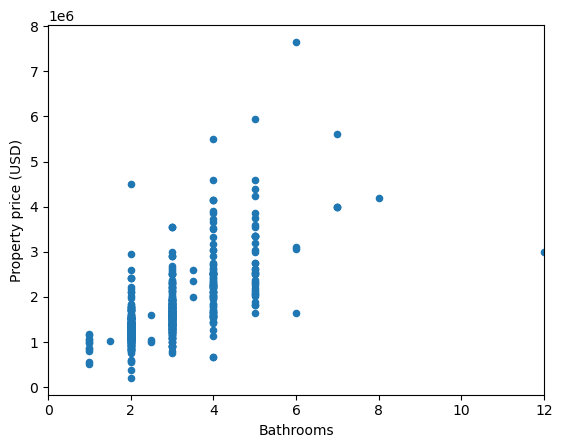

In [62]:
#Living Area vs Price
data = pd.concat([df_data['Property price (USD)'], df_data['Living area']], axis=1)
data.plot.scatter(y='Property price (USD)', x='Living area', ylim=(0,7800000))

#Land Area vs Price
data = pd.concat([df_data['Property price (USD)'], df_data['Lot/land area']], axis=1)
data.plot.scatter(y='Property price (USD)', x='Lot/land area', ylim=(0,7800000))

#Bedrooms vs Price
data = pd.concat([df_data['Property price (USD)'], df_data['Bedrooms']], axis=1)
data.plot.scatter(y='Property price (USD)', x='Bedrooms', ylim=(0,7800000))

#Bathrooms Vs Price
data = pd.concat([df_data['Property price (USD)'], df_data['Bathrooms']], axis=1)
data.plot.scatter(y='Property price (USD)', x='Bathrooms', xlim=(0,12))



Looking at the graph and thinking about the data in context it is a good idea to remove the 7 million dollar house from our data. Considering that the mean value of a home is 1.7 million dollars with a standard deviation of 800k, it would be a good idea to remove a house valued at 7.65 million and 1.5 million larger than the 2nd most expensive home. 

In [63]:
df_data = df_data[df_data['Property price (USD)'] < 7000000]
df_data = df_data[df_data['Bathrooms'] < 8]
df_data = df_data[df_data['Living area'] > 200]

Finally, we can remove all NaN's from the data.

In [64]:
df_data = df_data.dropna()

Now that our data is clean we can start on the creation of our model. We have to choose which factors we will use in our predictive model. We can make this choice by looking at the correlations between Property price (USD) and the other factors.

In [65]:
corrmat = df_data.corr(numeric_only=True)
print(corrmat)
#f, ax = plt.subplots(figsize=(8, 5))
#sns.heatmap(corrmat, vmax=.8, square=True);

                      Property price (USD)  Living area  Lot/land area  \
Property price (USD)                  1.00         0.79          -0.11   
Living area                           0.79         1.00          -0.03   
Lot/land area                        -0.11        -0.03           1.00   
Bedrooms                              0.29         0.54           0.35   
Bathrooms                             0.69         0.84          -0.18   

                      Bedrooms  Bathrooms  
Property price (USD)      0.29       0.69  
Living area               0.54       0.84  
Lot/land area             0.35      -0.18  
Bedrooms                  1.00       0.46  
Bathrooms                 0.46       1.00  


From this data we can tell that Living Area, Bathrooms and Bedrooms can be used to predict Property price (USD) while Lot/land Area cannot. So in our model 'Living area', 'Bedrooms', 'Bathrooms' will be our Features and 'Property price (USD)' will be our target.

In [66]:
x = df_data[['Living area', 'Bathrooms','Bedrooms']]  
y = df_data['Property price (USD)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


RMSE: 383319.7119723775
R-squared: 0.7322162292438659


In [67]:
coefficients_df = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])
print(coefficients_df)
print("Intercept:", model.intercept_)

             Coefficient
Living area       824.17
Bathrooms       26163.36
Bedrooms      -166086.50
Intercept: 492751.0424115835


# Analysis of Model
With a R-squared of .732 the model while not necessarily weak is not particularly strong. A y intercept of 492,751 shows that the model is not great at working around lower cost houses as there will always be an inaccuracy with anything below the price of 492,751. This tends to happen with models trying to predict housing, as large prices can skew the entire regression towards a higher number. The inaccuracies of this model result in a RMSE of $383,319.71. As the prices climb higher this RSME becomes less impactful but with the mean price of a house being 1.69 million dollars, prices shifting by 1/4th of that would not make this model optimal for the average home buyer. This model would be best served predicting the larger and generally more expensive beachfront property found in Huntington Beach. 

# Ways to Improve

<Figure size 640x480 with 0 Axes>

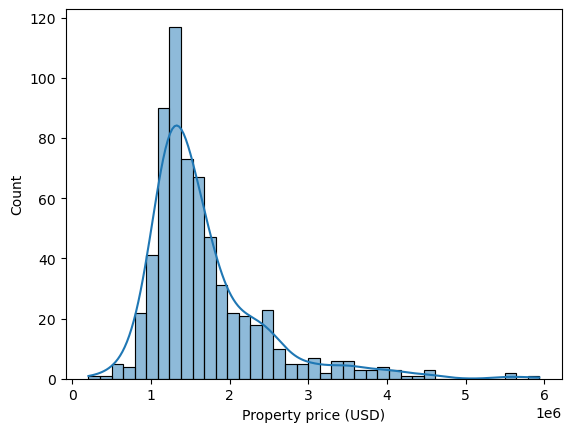

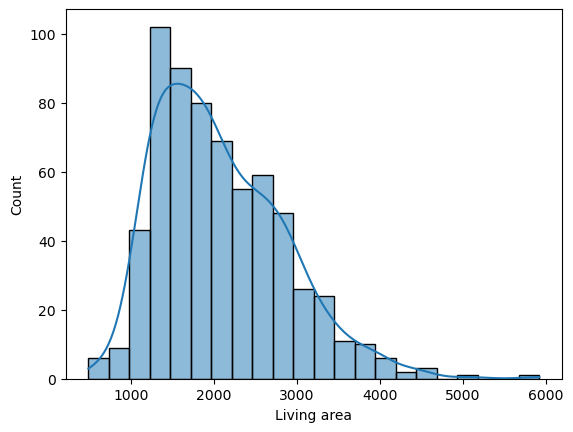

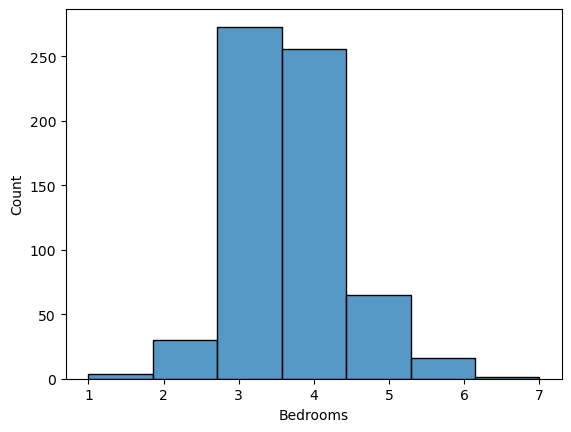

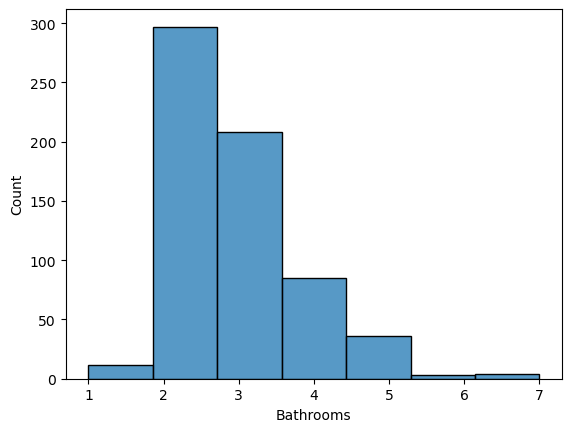

<Figure size 640x480 with 0 Axes>

In [68]:
sns.histplot(df_data['Property price (USD)'], kde =True);
plt.figure()

sns.histplot(df_data['Living area'], kde =True);
plt.figure()

sns.histplot(df_data['Bedrooms'], bins=7);
plt.figure()

sns.histplot(df_data['Bathrooms'], bins=7);
plt.figure()

As shown in these histograms the data used tends to skew right (except bedrooms). The normalization of the data would likely result in a more accurate model as it would reduce the impact of the skew.

Another route to go down is adding more features. Factors like location, age, and general house quality all have a massive impact on price and adding just one of these could significantly improve the accuracey of the model.

The final and arguably most obvious route for improvement is more data. A more accurate model can be made simply by increasing the amount of houses in the training and test samples.